#  Прогнозирование заказов такси

#### Описание работы :

Компания собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Необходимо постройть модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

#### Описание данных :

* `datetime` — временной интервал;
* `num_orders` — количество заказов такси за указанный временной интервал.

#### План работы над проектом :

1. [Подготовка данных](#Step_1)
2. [Анализ данных](#Step_2)
3. [Обучение моделей](#Step_3)
4. [Тестирование лучшей модели](#Step_4)
5. [Вывод](#Step_5)

## Подготовка данных <a id="Step_1"></a>

Загрузим всё необходимое для работы

In [1]:
import pandas as pd

import numpy as np

from statsmodels.tsa.seasonal import seasonal_decompose

from numpy import mean

import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from lightgbm import LGBMRegressor

from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor

In [2]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0], index_col = 'datetime')

In [3]:
df

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


Оценим имеющиеся данные стандартным набором инструментов

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


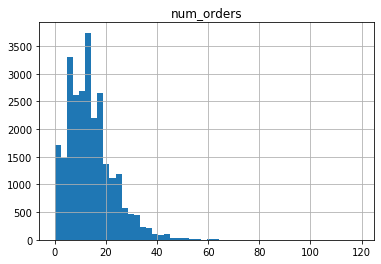

In [6]:
df.hist(bins = 50);

Ни аномалий тебе, ни пропусков, всё образцово-показательно.

Проверим расположены ли данные в хронологическом порядке.

In [7]:
df.index.is_monotonic

True

Расположены.

Выполним ресемплирование по одному часу. Агрегацию значений, согласно заданию, выполним суммой.

In [8]:
df = df.resample('1H').sum();

Результаты первого шага: 
1. Загрузили всё необходимое для работы; 
2. Произвели первичный анализ имеющейся информации;
3. Аномалии и пропуски отсутствуют;
4. Ресемплирование по одному часу с агрегацией значений суммой - выполнено.

## Анализ данных <a id="Step_2"></a>

Приступим к анализу с построения графика.

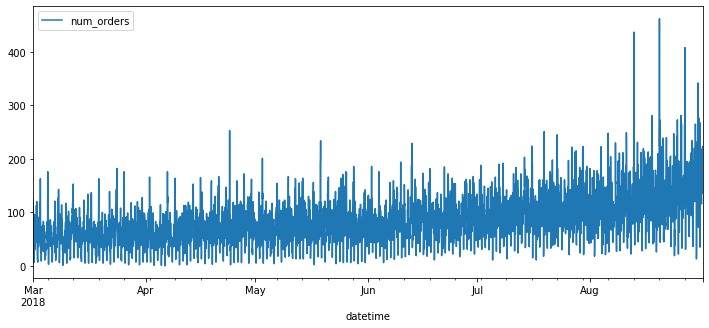

In [9]:
df.plot(figsize=(12, 5));

Не слишком информативно.

Для большей наглядности воспользуемся скользящим средним.

In [10]:
df_2 = df.copy()

In [11]:
df_2['rolling_mean'] = df_2.rolling(20).mean()

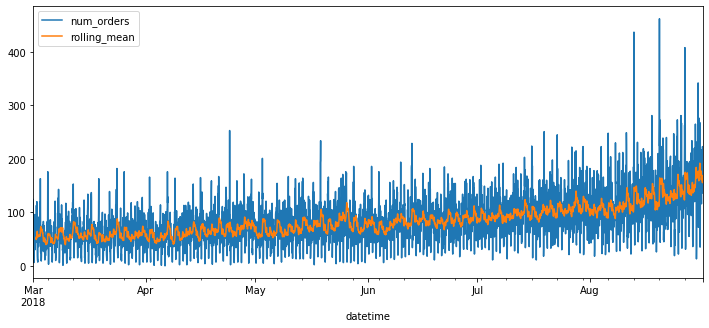

In [12]:
df_2.plot(figsize=(12, 5));

К концу выборки количество заказов явно набирает обороты.

Для лучшего понимания временного ряда исследуем данные на тренды и сезонность.

In [13]:
decomposed_1 = seasonal_decompose(df['2018-03-01':'2018-08-31'])

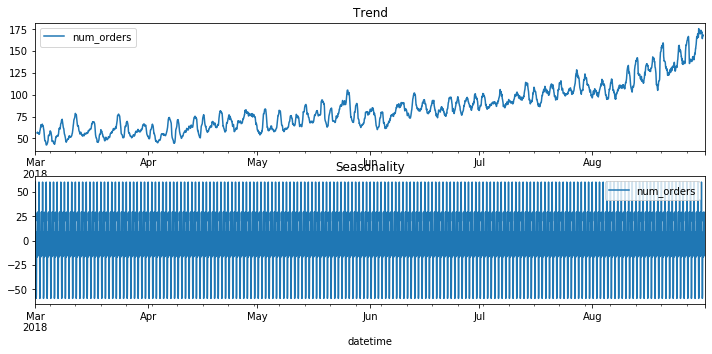

In [14]:
plt.figure(figsize=(12, 8))
plt.subplot(311)
decomposed_1.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_1.seasonal.plot(ax=plt.gca())
plt.title('Seasonality');

Как и скользящее среднее, составляющая тренда чётко указывает нам на возрастающее количество заказов в час ближе к осени. <br>
Что касается сезонности... Нужно уменьшить масштаб. 


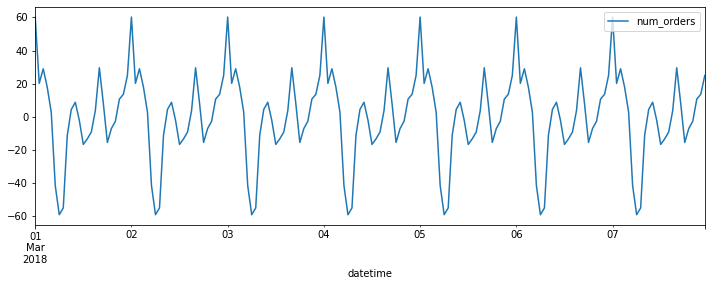

In [15]:
decomposed_1.seasonal['2018-03-01':'2018-03-07'].plot(figsize=(12, 4));

Другое дело.Если рассматривать почасовое количество заказов в течение недели, то отчётливо видно, что к полуночи спрос на такси достигает своего максимума. И так изо дня в день.

Произведём оценку ряда на стационарность. 

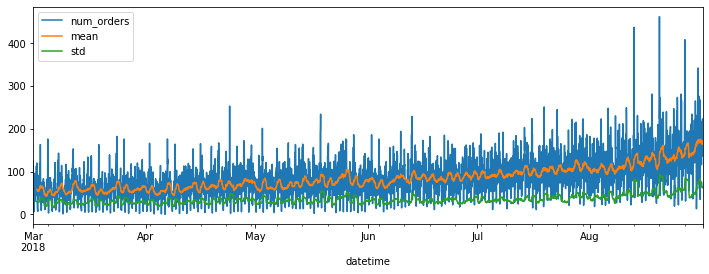

In [16]:
df['mean'] = df['num_orders'].rolling(25).mean()
df['std'] = df['num_orders'].rolling(25).std()
df.plot(figsize=(12, 4)); 

Ряд нестационарный, среднее и стандартное отклонения меняются, но весьма умеренно.

Так как среднее и стандартное отклонение свою роль выполнили, их можно убрать.

In [17]:
df.drop(['mean', 'std'], axis=1, inplace = True)

Подведём итоги второго этапа: 
1. Ближе к осеннему периоду количество заказов такси вырастает, что хорошо видно, как с помощью скользящей средней, так и при выделении тренда;
2. Также чётко прослеживается суточная сезонность, с максимумом ближе к полуноче;
3. Наш временной ряд не стационарный, но изменения среднего и стандартного отклонения лежат в определённом коридоре без резких скачков и изменений.

## Обучение моделей <a id="Step_3"></a>

Разделим данные.

In [18]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

Нашей базовой моделью в данном случае будет и не модель вовсе, а прогнозная оценка по предыдущему значению. От неё и оттолкнёмся.

In [19]:
pred_previous = test.shift(periods = 1, fill_value = train.iloc[3531, 0])

In [20]:
print("RMSE:", mean_squared_error(test, pred_previous) ** 0.5)

RMSE: 58.88016052260236


На 10 меньше необходимого. Время улучшить результаты) 

Далее создадим признаки для повышения качества прогноза.

In [21]:
def make_features(data, max_lag, rolling_mean_size):
    
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for i in range (1 , max_lag + 1): 
        columns = 'lag_' + str(i)
        data[columns] = data['num_orders'].shift(i)
        
    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

Используя модель линейной регрессии, подберём признаки с наибольшим значением `RMSE`. В теле цикла, по аналогии с тем как будет действовать далее, выделим обучающий, валидационный и тестовый набор данных. Определение оптимального количества признаков будем производить по `train` и `valid`.

In [22]:
rmse_list = []
lag_list = []
rol_list = []

for i in range (1,30):
    
    for j in range (1,55,5):
        
        df_1 = df.copy()
        
        make_features(df_1, i, j)
    
        train, test = train_test_split(df_1, 
                               test_size=0.2, 
                               random_state=42,
                               shuffle=False)
        
        train = train.dropna()
        
        valid, test = train_test_split(test, 
                               test_size=0.5, 
                               random_state=42,
                               shuffle=False)
    
        features_train = train.drop('num_orders', axis = 1)
        target_train = train['num_orders']

        features_valid = valid.drop('num_orders', axis = 1)
        target_valid = valid['num_orders']
    
        model = LinearRegression()
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        rmse = mean_squared_error(target_valid, predictions_valid) ** 0.5
        
        rmse_list.append(rmse)
        lag_list.append(i)
        rol_list.append(j)
        
columns = {
            "lag":np.array(lag_list),
            "rol": np.array(rol_list),
            "rmse": np.array(rmse_list),
          }

df_min_rmse = pd.DataFrame(columns)

df_min_rmse.query('rmse == rmse.min()')

,lag,rol,rmse
296,27,51,34.046181


Заявка на успех) Создаём соответствующие признаки в основном фрейме и двигаемся дальше.

In [23]:
make_features(df, 27, 36)

Разделим фрейм с новыми признаками на обучающую, валидационную и тестовую выборки.

In [24]:
train, test = train_test_split(df, 
                               test_size=0.1, 
                               random_state=42,
                               shuffle=False)

In [25]:
train = train.dropna()

In [26]:
valid, test = train_test_split(test, 
                               test_size=0.5, 
                               random_state=42,
                               shuffle=False)

Теперь создадим базовую, и на этот раз, именно модель для обычной линейной регрессии без изменения каких-либо гиперпараметров. Действие, больше, для порядка, так как результат нам, в принципе, уже извествен по результатам подбора признаков. </b>

Очевидно, что первый шаг, с построением прогноза по предыдущему значению для проверки адекватности построенных моделей, на даннном этапе уже не актуален. Полученное значение `RMSE` существенно превосходит не только такого рода прогноз, но и максимально допустимый порог для этой метрики, обозначенный в задании. 

In [27]:
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']

features_valid = valid.drop('num_orders', axis = 1)
target_valid = valid['num_orders']

In [28]:
model = LinearRegression()
model.fit(features_train, target_train)
predictions_valid = model.predict(features_valid)

print("RMSE:", mean_squared_error(target_valid, predictions_valid) ** 0.5)

RMSE: 44.54260460648931


Есть. Для исследования гиперпараметров выберем следующие виды моделей: 

1. `DecisionTreeRegressor`
2. `RandomForestRegressor`
3. `LGBMRegressor`

*`DecisionTreeRegressor`*

Исследуемым гиперпараметром в этом случае будет `max_depth`.

In [29]:
list_rmse_tree = []
max_depth_tree = []

for depth in range(1,21): 
    
    model = DecisionTreeRegressor(random_state=12345, max_depth= depth)
    model.fit(features_train,target_train)
    predictions_valid = model.predict(features_valid)
    
    rmse = mean_squared_error(target_valid, predictions_valid) ** 0.5 
    
    list_rmse_tree.append(rmse)
    max_depth_tree.append(depth)

columns = {
            "max_depth_tree":np.array(max_depth_tree),
            "rmse_tree": np.array(list_rmse_tree),
          }

df_min_rmse_tree = pd.DataFrame(columns)

df_min_rmse_tree.query('rmse_tree == rmse_tree.min()')

,max_depth_tree,rmse_tree
7,8,42.692312


Не плохо, но слабее, чем линейная регрессия.

*`RandomForestRegressor`*

Для случайного леса рассмотрим два гиперпараметра: `n_estimator` и `max_depth`.

In [30]:
list_rmse_forest = []
n_estimators_forest = []
max_depth_forest = []

for est in range(100,500,100):
    
    for depth in range(1,10): 
        
        model = RandomForestRegressor(random_state=12345,
                                      n_estimators = est,
                                      max_depth = depth)
        
        model.fit(features_train,target_train)
        predictions_valid = model.predict(features_valid)
        rmse = mean_squared_error(target_valid, predictions_valid) ** 0.5 
    
        list_rmse_forest.append(rmse)
        n_estimators_forest.append(est)
        max_depth_forest.append(depth)

columns = {
            "max_depth_forest":np.array(max_depth_forest),
            "n_estimators_forest":np.array(n_estimators_forest),
            "rmse_forest": np.array(list_rmse_forest),
          }

df_min_rmse_forest = pd.DataFrame(columns)

df_min_rmse_forest.query('rmse_forest == rmse_forest.min()')

,max_depth_forest,n_estimators_forest,rmse_forest
35,9,400,37.863296


Лучше предыдущего результата, но всё ещё хуже линейной регрессии.

*`LGBMRegressor`*

Для градиентного бустинга исследуем следующие гиперпараметры:
1. Количество деревьев;
2. Глубина дерева;
3. Скорость обучения.

Так как бустинг требует существенных временных ресурсов, а результаты, полученные при построении предыдущих моделей, выполняют условие установленное в проекте по величине `RMSE`, то при исследовании гиперпараметров в данном случае будем использовать минимальный разбег по используемым величинам.

In [31]:
list_rmse_lgbm = []
n_estimators_lgbm = []
max_depth_lgbm = []
rates_lgbm = []

for est in range(100,500,100):
    
    for depth in range(1,10):
        
        for rates in [0.01, 0.1, 1.0]:
        
            model = LGBMRegressor(random_state=12345, 
                              n_estimators = est,
                              max_depth = depth,
                              num_leaves = 2**depth,
                              learning_rate = rates)
        
            model.fit(features_train,target_train)
            predictions_valid = model.predict(features_valid)
            rmse = mean_squared_error(target_valid, predictions_valid) ** 0.5 
    
            list_rmse_lgbm.append(rmse)
            n_estimators_lgbm.append(est)
            max_depth_lgbm.append(depth)
            rates_lgbm.append(rates)

columns = {
            "max_depth_lgbm":np.array(max_depth_lgbm),
            "n_estimators_lgbm":np.array(n_estimators_lgbm),
            "rates_lgbm":np.array(rates_lgbm),
            "rmse_lgbm": np.array(list_rmse_lgbm),
          }

df_min_rmse_lgbm = pd.DataFrame(columns)

df_min_rmse_lgbm.query('rmse_lgbm == rmse_lgbm.min()')

,max_depth_lgbm,n_estimators_lgbm,rates_lgbm,rmse_lgbm
94,5,400,0.1,36.433822


Лучший результат!

Для наглядности создадим таблицу с `RMSE` для каждого типа моделей.

In [32]:
names = ['LinearRegression','DecisionTreeRegressor','RandomForestRegressor','LGBMRegressor']
column = {"rmse": np.array([33.76, 37.72, 34.26, 32.70])}
final_rmse = pd.DataFrame(column, index = names ) 

In [33]:
final_rmse

,rmse
LinearRegression,33.76
DecisionTreeRegressor,37.72
RandomForestRegressor,34.26
LGBMRegressor,32.70


## Тестирование лучшей модели <a id="Step_4"></a>

Теперь проверим нашу лучшую модель с соответствующими гиперпараметрами на тестовой выборке.

In [34]:
train, test = train_test_split(df, 
                               test_size=0.1, 
                               random_state=42,
                               shuffle=False)

In [35]:
train = train.dropna()

In [36]:
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

In [37]:
model_test = LGBMRegressor(random_state=12345, 
                        n_estimators = 100,
                        max_depth = 9,
                        num_leaves = 2**9,
                        learning_rate = 0.1)

model_test.fit(features_train,target_train)
predictions_test = model_test.predict(features_test)
print("RMSE_test:", mean_squared_error(target_test, predictions_test) ** 0.5)


RMSE_test: 41.81275978948918


Хуже, чем на валидационной выборке, но условие по `RMSE` выполняется.

Для наглядности качества прогноза построим соответствующий график по данных последней модели. Интервал дял построения возьмём 2 дня.

In [65]:
target = target_test['2018-08-13':'2018-08-15']

In [66]:
predict = pd.Series(list(predictions_test)[:58], target.index)

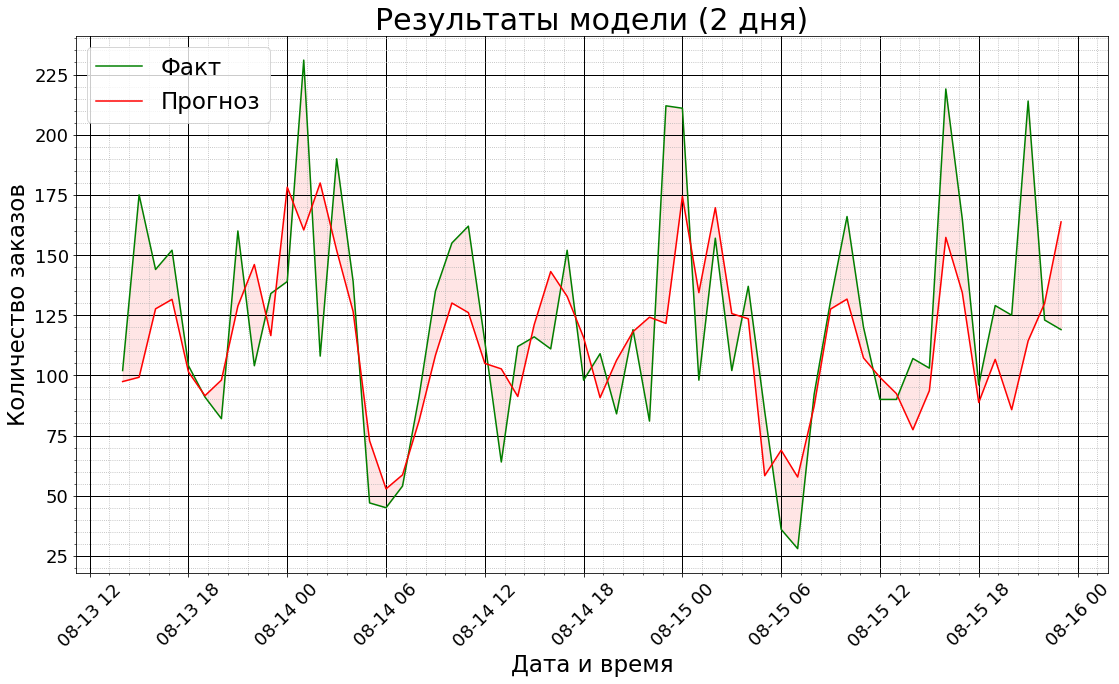

In [128]:
plt.figure(figsize=(15, 8))
plt.plot(target, color='g', label="Факт")
plt.plot(predict, color='r', label="Прогноз")
plt.legend(fontsize = 23)
plt.grid(True)
plt.minorticks_on()
plt.grid(which='minor', linestyle=':')
plt.grid(which='major', linewidth= 1, color = 'black')
plt.tight_layout()
plt.xlabel('Дата и время', fontsize = 23)
plt.ylabel('Количество заказов', fontsize = 23)
plt.title('Результаты модели (2 дня)', fontsize = 30)
plt.tick_params(labelsize = 18)
plt.xticks(rotation = 45)
plt.fill_between(target.index, target, predict,color="r",alpha = 0.1);

На графике хорошо видно, что, несмотря на приемлимую для задания величину `RMSE`, расхождения с фактическим числом заказов достаточно значительны, что в реальных условиях означало бы дальнешую доработку модели, так как каждое такое расхождение - это деньги, и чем оно больше, тем существенне потери. 

## Вывод <a id="Step_5"></a>

По результатам проведённых рассчётов и исследований, удалось построить модель градиентного бустинга `LGBMRegressor` (гиперпараметры `n_estimators = 100`, `max_depth = 9`, `num_leaves = 2**9`, `learning_rate = 0.1`), на основании которой возможно осуществлять почасовое прогнозирование количества заказов в аэропортах для привлечения соответствующего количества водителей. Величина `RMSE` для нашей модели составляет 42.63, что ниже максимально установленного в задаче уровня для данной метрики (48). Таким образом поставленная задача успешно решена, поставленный требования выполнены.